In [1]:
# !pip install tensorflow==2.9.1 keras==2.9.0
# !pip install keras-ocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.7 MB/s eta 0:00:00


In [3]:
!unzip /content/License-Characters-by-2-27classes.zip -d /content/Dataset-2/

Archive:  /content/License-Characters-by-2-27classes.zip
   creating: /content/Dataset-2/License-Characters-by-2-27classes/
  inflating: /content/Dataset-2/__MACOSX/._License-Characters-by-2-27classes  
   creating: /content/Dataset-2/License-Characters-by-2-27classes/test/
  inflating: /content/Dataset-2/__MACOSX/License-Characters-by-2-27classes/._test  
   creating: /content/Dataset-2/License-Characters-by-2-27classes/train/
  inflating: /content/Dataset-2/__MACOSX/License-Characters-by-2-27classes/._train  
  inflating: /content/Dataset-2/License-Characters-by-2-27classes/test/ckn76r7kl009a3068blod1qdc.txt  
  inflating: /content/Dataset-2/__MACOSX/License-Characters-by-2-27classes/test/._ckn76r7kl009a3068blod1qdc.txt  
  inflating: /content/Dataset-2/License-Characters-by-2-27classes/test/ckn76nixr008m3068mquo57qh.jpeg  
  inflating: /content/Dataset-2/__MACOSX/License-Characters-by-2-27classes/test/._ckn76nixr008m3068mquo57qh.jpeg  
  inflating: /content/Dataset-2/License-Charact

In [4]:
import random
import string
import math
import itertools
import os

import numpy as np
import pandas as pd
import imgaug
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

import keras_ocr
from tensorflow.keras.models import load_model


import xml.etree.ElementTree as ET

import cv2

In [10]:
recognizer = keras_ocr.recognition.Recognizer(alphabet='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
recognizer.compile()
# recognizer.model.load_weights('/content/OCR_KERAS_MODEL.h5')

# recognizer = load_model('/content/OCR_KERAS_MODEL.h5').Recognizer(alphabet='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
# recognizer.compile()

Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for /root/.keras-ocr/crnn_kurapan_notop.h5


In [5]:
# Define the directory where the XML files and images are stored
xml_dir = '/content/Dataset-2/License-Characters-by-2-27classes/train'  # Update with the correct path
image_dir = '/content/Dataset-2/License-Characters-by-2-27classes/train'  # Update with the correct path

def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find('filename').text

    labels = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        labels.append(label)

    return filename, labels

def has_three_alphabets(labels):
    alphabet_count = sum([1 for label in labels if label.isalpha()])
    return alphabet_count == 3

image_labels = []
for xml_filename in os.listdir(xml_dir):
    if xml_filename.endswith('.xml'):
        xml_file_path = os.path.join(xml_dir, xml_filename)

        image_filename, labels = parse_xml(xml_file_path)

        if has_three_alphabets(labels):
            image_path = os.path.join(image_dir, image_filename)
            image_labels.append((image_path, labels))

In [8]:
def format_labels_for_ocr(image_labels):
    formatted_labels = []
    for image_path, labels in image_labels:
        text_label = ''.join(labels)
        formatted_labels.append((image_path, None, text_label))
    return formatted_labels

train_data, validation_data = sklearn.model_selection.train_test_split(image_labels, test_size=0.15, random_state=42)

formatted_train_data = format_labels_for_ocr(train_data)
formatted_validation_data = format_labels_for_ocr(validation_data)


In [9]:
import imgaug.augmenters as iaa

augmenter = iaa.Sequential([
    iaa.GammaContrast(gamma=(0.25, 3.0)),  # Existing contrast augmentation
    iaa.GaussianBlur(sigma=(0, 3.0)),      # Add Gaussian Blur
    iaa.Affine(rotate=(-15, 15)),          # Rotate between -15 to +15 degrees
    iaa.Fliplr(0.5),                       # Horizontally flip 50% of images
    iaa.Multiply((0.8, 1.2)),              # Change brightness
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Add Gaussian noise
])

In [15]:
import numpy as np

def augment_data(data, recognizer, n_augmentations=5):
    augmented_data = []
    for image_path, _, text_label in data:
        image = keras_ocr.tools.read(image_path)

        for _ in range(n_augmentations):
            augmented_image = augmenter.augment_image(image)

            # Save the augmented image and associate it with the same text label
            augmented_data.append((augmented_image, text_label))

    return augmented_data

# Augment the training data to increase the dataset size
augmented_train_data = augment_data(formatted_train_data, recognizer, n_augmentations=5)

# Format the augmented data for Keras OCR
formatted_augmented_train_data = format_labels_for_ocr(augmented_train_data)

In [16]:
augmented_val_data = augment_data(formatted_validation_data, recognizer, n_augmentations=5)
formatted_augmented_val_data = format_labels_for_ocr(augmented_val_data)


In [13]:
len(formatted_augmented_train_data)

2105

In [17]:
batch_size = 8

def format_data_for_keras_ocr(data, recognizer):
    image_gen = keras_ocr.datasets.get_recognizer_image_generator(
        labels=data,
        height=recognizer.model.input_shape[1],
        width=recognizer.model.input_shape[2],
        alphabet=recognizer.alphabet,
        # augmenter=augmenter
    )
    steps = len(data) // batch_size
    return recognizer.get_batch_generator(
        image_generator=image_gen,
        batch_size=batch_size
    ), steps


In [18]:
(training_gen, training_steps), (validation_gen, validation_steps) = [
    format_data_for_keras_ocr(data, recognizer) for data in [formatted_augmented_train_data, formatted_validation_data]
]

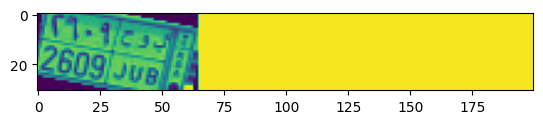

In [21]:
image, text = next(training_gen)
plt.imshow(image[0][0].squeeze())

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
    tf.keras.callbacks.ModelCheckpoint('recognizer_saudi_license_plate.h5', save_best_only=True),
    tf.keras.callbacks.CSVLogger('recognizer_training_log.csv')
]

recognizer.training_model.fit_generator(
    generator=training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=20
)

Epoch 1/20


<ipython-input-24-82dc28ec98f6>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  recognizer.training_model.fit_generator(


263/263 [==============================] - 2055s 8s/step - loss: 19.6978 - val_loss: 19.0356
Epoch 2/20
263/263 [==============================] - 2032s 8s/step - loss: 17.6787 - val_loss: 18.6065
Epoch 3/20
263/263 [==============================] - 2034s 8s/step - loss: 16.6430 - val_loss: 16.2613
Epoch 4/20
263/263 [==============================] - 2033s 8s/step - loss: 16.3377 - val_loss: 16.4874
Epoch 5/20
263/263 [==============================] - 2026s 8s/step - loss: 15.8443 - val_loss: 16.3315
Epoch 6/20
263/263 [==============================] - 2030s 8s/step - loss: 15.4820 - val_loss: 15.7834
Epoch 7/20
263/263 [==============================] - 2030s 8s/step - loss: 15.1995 - val_loss: 15.4431
Epoch 8/20
263/263 [==============================] - 2027s 8s/step - loss: 14.8392 - val_loss: 16.2978
Epoch 9/20
263/263 [==============================] - 2026s 8s/step - loss: 14.4708 - val_loss: 16.4063
Epoch 10/20
263/263 [==============================] - 2024s 8s/step - loss

1/1 [==============================] - 0s 483ms/step
Predicted License Plate Text: 7836VXJ


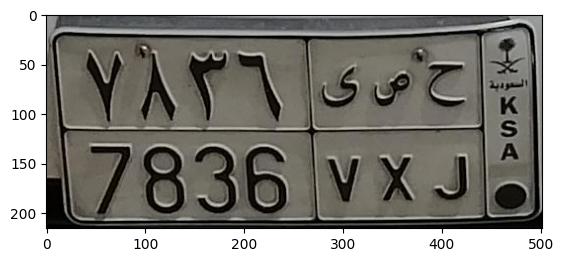

In [44]:
image_filepath = '/content/Dataset/License-Characters-by-2-27classes/train/ckiczyhvx0025246aw1urmz65.jpeg'
predicted = recognizer.recognize(image_filepath)
plt.imshow(keras_ocr.tools.read(image_filepath))
print(f'Predicted License Plate Text: {predicted}')

In [1]:
recognizer.model.save('OCR_KERAS_MODEL.h5')

NameError: name 'recognizer' is not defined

## Testing Later

In [ ]:
image_filepath, _, actual = test_labels[1]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))

In [ ]:
recognizer.model.load_weights('recognizer_borndigital.h5')